## Задача:

    Используя метод линейной регрессии из библиотеки PyTorch
    решить задачу предсказания цены дома исходя из имеющей о нём информации.

In [16]:
import torch
import torchvision
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from torch.autograd import Variable
from sklearn.model_selection import train_test_split

%matplotlib inline

    Посмотрим на наши данные.

In [17]:
data = pd.read_csv('../data/housing.csv')
data.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


    Они представляют собой таблицу с информацией об объектах недвижимости в Калифорнии за 1990 год.

In [18]:
data.shape

(20640, 10)

    Всего в таблице 20640 объектов.

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


    10 признаков: 9 числовых, 1 категориальный.

    Имеются пропуски в признаке total_bedrooms: 207 пропусков.
    Можно будет их заполнить неким усреднённым значением, например медианой.

In [20]:
data.total_bedrooms.fillna(data.total_bedrooms.median(), inplace=True)

    Целевой признак: median_house_value.

In [21]:
target = 'median_house_value'

In [22]:
std = data.describe().loc['mean':'std',:]
cols = list(std.columns)
cols.remove(target)
for col in cols:
    data[col] = (data[col]-std[col]['mean'])/std[col]['std']

    Информация о признаках:

1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

## О методе линейной регрессии

Будем использовать множественную линейную регрессию, т.к. работаем с несколькими признаками. 
В основе метода лежит предположение о том, что значение целевого признака является линейной функцией 
от нескольких переменных (плюс шум). И суть заключается в том, чтобы подобрать наилучшее приближение
такой функции. Подбор осуществляется изменением «весов» линейной модели,
оценка «наилучшости» — с помощью метрики, измеряющей расхождение между предсказанным и реальным
результатами.

Данные, которые мы будем получать из таблицы, носят название «объясняющих переменных». Мы не можем на них никак влиять, и можем лишь раздать им «веса» в соответствии с тем, какой вклад они вносят в результат. Обозначим их $x_1, x_2, \dots, x_p$. Пресловутые веса, меняя которые мы хотим достигнуть наилучшего приближения, обозначим $w_1, w_2, \dots, w_p$. Константная составляющая — $w_0$. Тогда общий вид функции будет таким: $ \widehat{y} = w_0 + w_1x_1 + w_2x_2 + \dots + w_px_p $. Добавим фиктивную переменную $ x_0 = 1 $ и перепишем функцию компактнее: $\large{ \widehat{y} = \sum_{i=0}^{p}{w_ix_i} = w^Tx}$, где $ x = (x_0, x_1, \dots, x_p) $.

Зададим модель следующим образом:

$ \Large{y = Xw + \epsilon} $

где $ w $ — вектор весов модели


$ X $ — матрица из $ n $ строк (наблюдений) и $ p + 1 $ столбцов <br>(p объясняющих переменных + $ x_0 = 1 $)

$ \epsilon $ — шум (неустранимая ошибка в наблюдениях)

Формула для объясняемого значения каждого отдельного наблюдения соответственно будет иметь такой вид:

$ \large{y_i = \sum_{j=0}^{p}{w_j X_{ij}} + \epsilon_i} $

На модель (а точнее на гипотезу о том, какой у нас шум) накладываются следующие ограничения (из теормы Гаусса-Маркова):
    
1. $ \mathbb{E}\epsilon_i=0, \, \forall i $
2. $ \mathbb{D}\epsilon_i=\sigma^2 < \infty, \, \forall i $
3. $ cov(\epsilon_i, \epsilon_j) = \mathbb{E}(\epsilon_i - \mathbb{E}\epsilon_i)(\epsilon_j - \mathbb{E}\epsilon_j) = 0, \, \forall i \neq j $

Если они не выполняются, то линейной регрессией это уже не назовёшь.

Известны следующие метрики для линейных моделей, измеряющие «близость» к реальному результата, полученного в результате работы модели.

1. Mean Absolute Error (MAE or L1)
2. Mean Square Error (MSE or L2)
3. Huber Loss
4. Log-cosh Loss
5. Quantile Loss

Последние три являются являются достачно экзотичными и их использование может быть оправдано спецификой данных (много незначащих выбросов в данных, MSE к этому не слишком устойчива — правильный выбор параметра для Хьюбера поможет), выбором метода (log-cosh используют например при работе с XGBoost, потому  что обладает преимуществами предыдущей функции и кроме того дважды дифференцируема, что важно для алгоритмов) или же требуемым форматом ответа на задачу (например в квантильной регресии одноимённая функция потерь позволяет получать более точные предсказания границ интервалов, если остатки не распределены нормально или их дисперсия непостоянна).

Потому будем выбирать между L1 и L2.

Так выглядит формула для Mean Absolute Error:
    
$ \Large{MAE = \frac{\sum_{i=1}^{n}|y_i-\hat{y_i}|}{n}} $

Так — для Mean Square Error:

$ \Large{MSE = \frac{\sum_{i=1}^{n}(y_i-\hat{y_i})^2}{n}} $

Будем искать наилучшую оценку параметров модели в классе линейных и несмещенных оценок. Именно для этого мы требуем выполнения условий теормы Гаусса-Маркова. И поэтому будем минимизировать среднеквадратичную ошибку, т.к. в случае использования MAE условия теоремы выполняться уже не будут.

Решим аналитически оптимизационную задачу минимизации MSE:

$ \Large{L = \frac{\sum_{i=1}{n}{(y_i-w^T x_i)}}{n} = \frac{||y-Xw||_2^2}{n} = \frac{(y-Xw)^T(y-Xw)}{n} } $

Дифференцируем:

$ \Large{\frac{\partial{L}}{\partial{w}}} = \frac{\partial{}}{\partial{w}} \frac{1}{n} \bigl(y^Ty-2y^TXw+w^TX^TXw\bigr) = \frac{1}{n} \bigl(-2X^Ty+2X^TXw\bigr) $

Приравниваем к нулю:

$ \Large{\frac{\partial{L}}{\partial{w}}} = 0 \Leftrightarrow X^TXW=X^Ty \Leftrightarrow w=\bigl(X^TX\bigr)^{-1}X^Ty$

В принципе, тот же самый результат можно получить, если использовать вероятностный подход — сделать предположение о том, что шум распределён нормально с нулевым матожиданием и дисперсией $ \sigma^2 $. Далее, пользуясь свойствами нормального распределения, расписать функцию плотности и максимизируя логарифм правдоподобия, получить тот же самый результат. Т.е. минимизация среднеквадратичной ошибки с описанными ограничениями на модель эквивалентна максимизации правдоподобия данных и это является следствием того факта, что ошибки распределены нормально. Если они распределены нормально. На модельной задаче это почти наверное так и есть, но проверить не помешает.

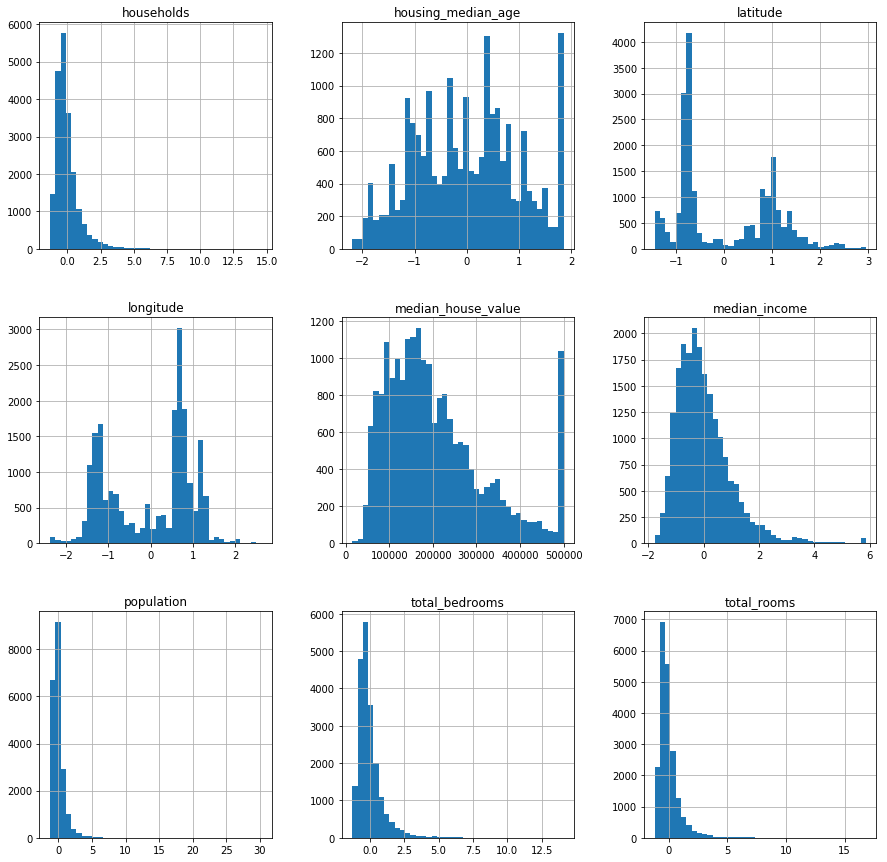

In [23]:
data.hist(figsize=(15,15), bins=40);

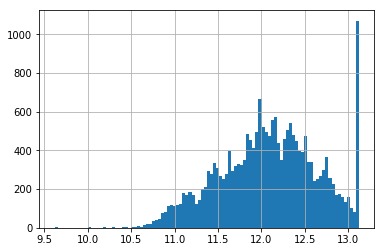

In [25]:
np.log(data.median_house_value).hist(bins=100);

In [26]:
correlation_matrix = data.corr()
correlation_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924664,-0.108197,0.044568,0.069120,0.099773,0.055310,-0.015176,-0.045967
latitude,-0.924664,1.000000,0.011173,-0.036100,-0.066484,-0.108785,-0.071035,-0.079809,-0.144160
housing_median_age,-0.108197,0.011173,1.000000,-0.361262,-0.319026,-0.296244,-0.302916,-0.119034,0.105623
total_rooms,0.044568,-0.036100,-0.361262,1.000000,0.927058,0.857126,0.918484,0.198050,0.134153
total_bedrooms,0.069120,-0.066484,-0.319026,0.927058,1.000000,0.873535,0.974366,-0.007617,0.049457
population,0.099773,-0.108785,-0.296244,0.857126,0.873535,1.000000,0.907222,0.004834,-0.024650
households,0.055310,-0.071035,-0.302916,0.918484,0.974366,0.907222,1.000000,0.013033,0.065843
median_income,-0.015176,-0.079809,-0.119034,0.198050,-0.007617,0.004834,0.013033,1.000000,0.688075
median_house_value,-0.045967,-0.144160,0.105623,0.134153,0.049457,-0.024650,0.065843,0.688075,1.000000


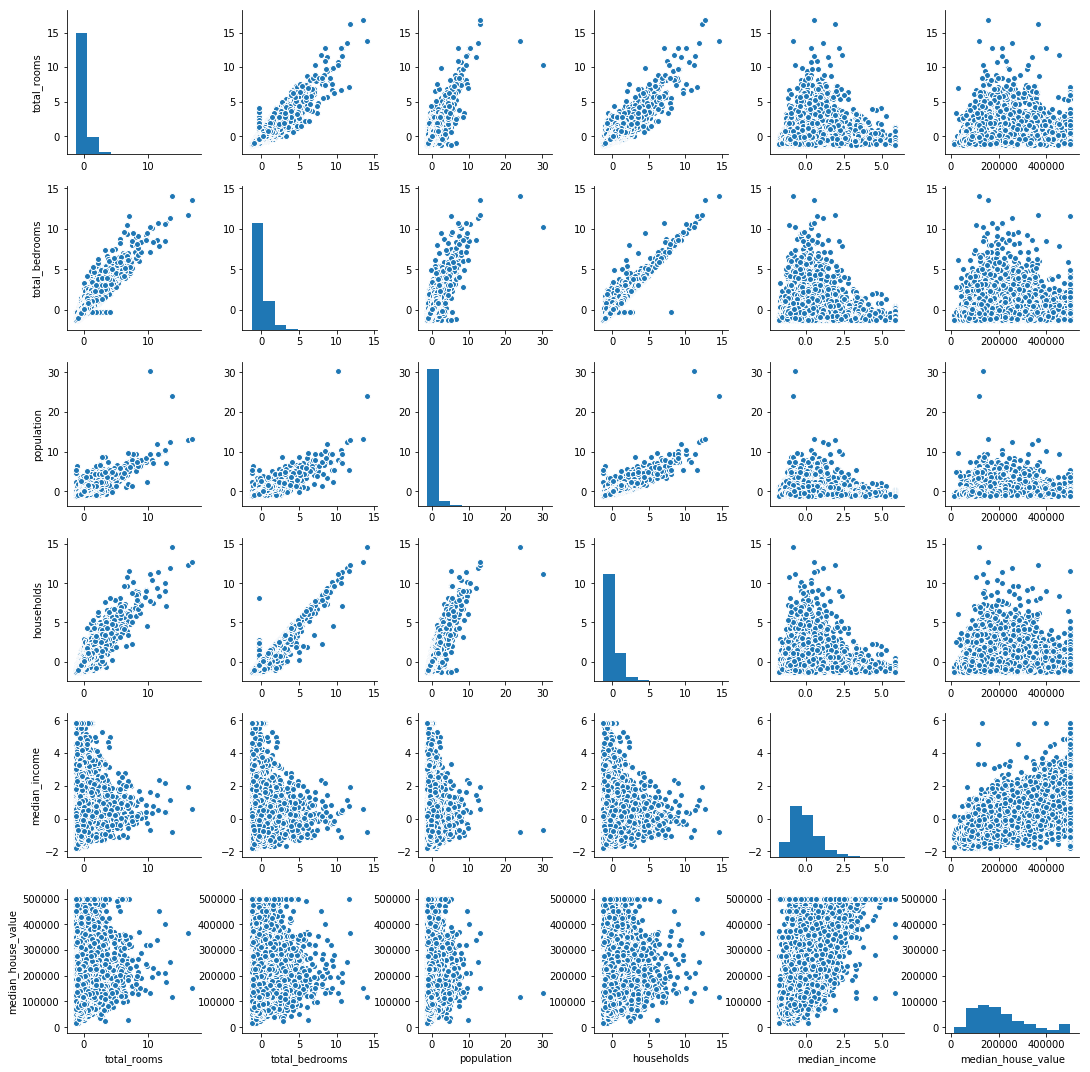

In [27]:
np.fill_diagonal(correlation_matrix.values, 0)
strongly_correlated = correlation_matrix.loc[lambda row: row.max() > 0.6].index
sns.pairplot(data[strongly_correlated]);

In [28]:
oceanity = list(data.ocean_proximity.unique())
for value in oceanity:
    kwargs = {value : data.ocean_proximity.apply(lambda x: 1 if x == value else 0)}
    data = data.assign(**kwargs)
data.drop('ocean_proximity', axis=1, inplace=True)

In [29]:
data = data[cols+oceanity+[target]]